# Configuring and applying the CNN model in the input dataset

*Based on Hands-on presented on 23/07/2021.*

## Context
The goal of this project is to detect convective systems based on a combination of ABI bands images that highlight different features of these systems by training a convolutional neural network model. The model applied here is composed of 4 layers of [2D image convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

## 0. Loading necessary packages

In [1]:
import pickle
import random

import numpy  as np
import matplotlib.pyplot as plt

import tensorflow as tf
import sklearn.preprocessing
import sklearn.model_selection

## 1. Loading input data

The loaded files are consisted of pickle objects with lists of arrays. Each array has a shape of 150 x 150 pixels (made in the script `mask_systems.py`) and the values are normalized between 0 and 1 made in the script `preprocess_model_input.py`.

![](data/nomask_random.png)
### Fig. 1: Example of unmasked/random images before normalization.

*Because of a problem when generating the masked dataset, it will not be used here. However, the unmasked dataset can be considered as "good" as a correct masked dataset because it's centered on the convective system detected by the tracking algorithm.*

In [2]:
# with open("data/norm_mask.pickle", "rb") as input:
#     imgs_masked = pickle.load(input)
with open("data/norm_nomask.pickle", "rb") as input:
    imgs_unmasked = pickle.load(input)
with open("data/norm_random.pickle", "rb") as input:
    imgs_random = pickle.load(input)

# print("Masked images available", len(imgs_masked))
print("Unmasked images available:", len(imgs_unmasked))
print("Random images available:", len(imgs_random))

img_size = 150  # array size in each dimension

Unmasked images available: 4544
Random images available: 1500


Since there's more unmasked than random images, it's necessary to take a (random) sample of the images before joining both datasets.

In [3]:
smp_unmasked = random.sample(imgs_unmasked, 1500)
print("Unmasked images available:", len(smp_unmasked))
imgs = imgs_random + smp_unmasked
print("Total images available:", len(imgs))

Unmasked images available: 1500
Total images available: 3000


Next, binary labels are created based on the order of the list created above:
- `no_convection` = `0` = `[1, 0]`: random images
- `convection` = `1` = `[0, 1]`: unmasked images

In [4]:
labels = np.repeat([0, 1], 1500, axis=0)
oh_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
oh_labels = oh_encoder.fit_transform(np.reshape(labels, (3000,1)))
print(oh_labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## 2. Creating the model inputs

`imgs` list input is splitted in two steps:

1. Training + validation (90%) and testing (10%) datasets
2. Training (80%) and validation (20%) datasets

Making a total of 70% training, 20% validation and 10% testing.

Another test was made with 60% training, 20% validation and 10% testing. The saved model can be loaded with the code below:

```
loaded_model = tf.keras.models.load_model('data/cnn_test_80_20', compile=False)
```

In [5]:
# Creating model inputs
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(imgs, oh_labels, stratify=oh_labels, test_size=.1, random_state=0)
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x_train, y_train, stratify=y_train, test_size=.2, random_state=0)

# Converting to arrays
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test  = np.array(x_test)

The plot below shows that all three model inputs as proportionally divided within classes.

Text(0.5, 0, 'Class')

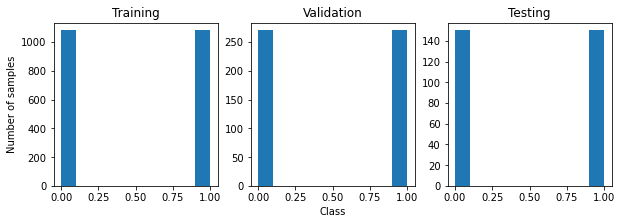

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

ax[0].hist(np.argmax(y_train, axis=1))
ax[0].set_title('Training')
ax[1].hist(np.argmax(y_valid, axis=1))
ax[1].set_title('Validation')
ax[2].hist(np.argmax(y_test, axis=1))
ax[2].set_title('Testing')

ax[0].set_ylabel('Number of samples')
ax[1].set_xlabel('Class')

## 3. Creating the model

The code below creates the CNN model of 4 convolutional layers with the `Adam` optimizer and minimizing the `binary_crossentropy` loss.

In [7]:
Input   = tf.keras.layers.Input

Conv2D  = tf.keras.layers.Conv2D
MaxPool = tf.keras.layers.MaxPooling2D
Flatten = tf.keras.layers.Flatten
Dropout = tf.keras.layers.Dropout
Dense   = tf.keras.layers.Dense

def Convolutional_Model():
    Input_Layer = Input(shape=(img_size, img_size, 1))

    l = Conv2D(filters=16, kernel_size=2, activation='relu')(Input_Layer)
    l = MaxPool(2)(l)

    l = Conv2D(filters=32, kernel_size=2, activation='relu')(l)
    l = MaxPool(2)(l)

    l = Conv2D(filters=64, kernel_size=2, activation='relu')(l)
    l = MaxPool(2)(l)
    
    l = Conv2D(filters=128, kernel_size=2, activation='relu')(l)
    l = MaxPool(2)(l)
    
    l = Flatten()(l)
    
    l = Dropout(0.5)(l)
    l = Dense(256, activation='relu')(l)
    
    Output_Layer = Dense(2, activation='softmax')(l)
    
    model = tf.keras.models.Model(inputs=Input_Layer, outputs=Output_Layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model

## 4. Applying the model

The code below summarizes the model created above and applies it on the training dataset with the validation dataset.

The number of steps (`epochs`) chosen was 50, to ensure that the model can be run in a local machine, and the number os samples used in each iteration (`batch_size`) is 100.

In [8]:
cnn = Convolutional_Model()

# Seeing the details of the network
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 149, 149, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [9]:
# Fitting the model
cnn_fit = cnn.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, batch_size=100, verbose=1)

Epoch 1/50
22/22 [==============================] - 11s 416ms/step - loss: 0.6906 - binary_accuracy: 0.5166 - val_loss: 0.6417 - val_binary_accuracy: 0.5574
Epoch 2/50
22/22 [==============================] - 7s 310ms/step - loss: 0.6087 - binary_accuracy: 0.7101 - val_loss: 0.3794 - val_binary_accuracy: 0.8722
Epoch 3/50
22/22 [==============================] - 7s 324ms/step - loss: 0.4104 - binary_accuracy: 0.8395 - val_loss: 0.2795 - val_binary_accuracy: 0.9148
Epoch 4/50
22/22 [==============================] - 9s 391ms/step - loss: 0.3416 - binary_accuracy: 0.8658 - val_loss: 0.3550 - val_binary_accuracy: 0.8352
Epoch 5/50
22/22 [==============================] - 10s 460ms/step - loss: 0.3068 - binary_accuracy: 0.8882 - val_loss: 0.2081 - val_binary_accuracy: 0.9315
Epoch 6/50
22/22 [==============================] - 8s 365ms/step - loss: 0.2197 - binary_accuracy: 0.9223 - val_loss: 0.2195 - val_binary_accuracy: 0.9259
Epoch 7/50
22/22 [==============================] - 8s 342ms/s

In [10]:
# Saving the model
cnn.save('data/cnn_test_90_10', overwrite=False)

INFO:tensorflow:Assets written to: data/cnn_test_90_10/assets


## 5. Evaluating model performance

The plot below shows the model performance in terms of accuracy and loss between the training and validation datasets by the epochs. In both plots, the validation curves tend to move far away (lower accuracy, higher loss) from the training curves with epochs above 20, showing a tendency of overfitting. In this sense, the value of epoch chosen was adequate to avoid larger overfitting.

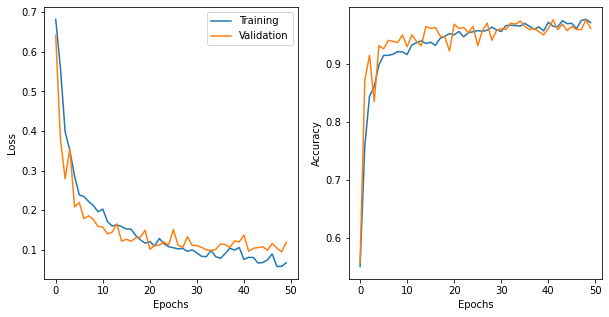

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Plot the training loss and validation loss
ax[0].plot(cnn_fit.history['loss'], label='Training')
ax[0].plot(cnn_fit.history['val_loss'], label='Validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot the training and validation accuracy
ax[1].plot(cnn_fit.history['binary_accuracy'])
ax[1].plot(cnn_fit.history['val_binary_accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()

The code below evaluates the model in the test dataset. The high accuracy (0.96) and low loss (0.12) shows that the model had a good overall performance.

In [12]:
cnn.evaluate(x_test, y_test)

10/10 [==============================] - 0s 28ms/step - loss: 0.1167 - binary_accuracy: 0.9600


[0.11668813228607178, 0.9599999785423279]

## Conclusions

This application shows that a CNN model can be used to detect cloud convection with a high accuracy even with the variety of bands (and different features) included. The dataset used as input is considerably small for this type of application (due to computational limitations and the large amount of data involved, it was not possible to use a larger dataset), which contributes to the overfitting observed. An improvement to this application would be to add the channel band as a layer of each array and include it in the model, to better understand which band is better for the detection.